In [ ]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [ ]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-24 Vero Rd hTERT CK-99c ISK-1 + CK-122 Slovesnova\0H plates"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


Extract wellmaps and combine into one df with names of the images

In [ ]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [ ]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

Add images names to data (thank you CellProfiler for convenience)

In [49]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate.columns)

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank', 'conc_uM',
       'cells', 'uv', 'RZ_incubation', 'substance', 'substance_incubation',
       'culture_type', 'control'],
      dtype='object')


0H plate as a reference plate

0     2024-07-24 hTERT ISK-1 0H (Multichannel).tif
1     2024-07-24 hTERT ISK-1 0H (Multichannel).tif
2     2024-07-24 hTERT ISK-1 0H (Multichannel).tif
3     2024-07-24 hTERT ISK-1 0H (Multichannel).tif
4     2024-07-24 hTERT ISK-1 0H (Multichannel).tif
                          ...                     
91    2024-07-24 hTERT ISK-1 0H (Multichannel).tif
92    2024-07-24 hTERT ISK-1 0H (Multichannel).tif
93    2024-07-24 hTERT ISK-1 0H (Multichannel).tif
94    2024-07-24 hTERT ISK-1 0H (Multichannel).tif
95    2024-07-24 hTERT ISK-1 0H (Multichannel).tif
Name: FileName_RGB, Length: 96, dtype: object


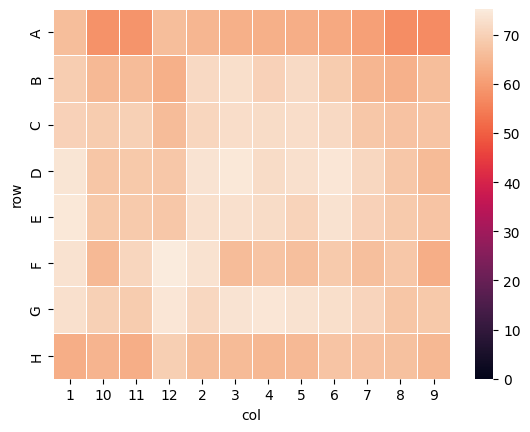

In [37]:
reference_plate = data_plate[(data_plate['RZ_incubation'] == '0H')].copy()

# print(reference_plate)

heatmap_df = reference_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

print(reference_plate['FileName_RGB'])

0.012623688210673799
0     0.969689
1     1.012413
2     1.024112
3     1.080141
4     1.089947
        ...   
91    0.995381
92    0.996012
93    1.100155
94    1.083639
95    1.018263
Name: Mean_dif, Length: 96, dtype: float64


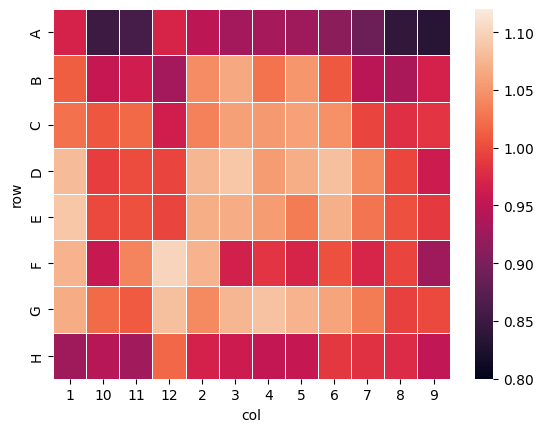

In [74]:
# mean_array_reference_plate = []

# for p in plate:
#     mean = reference_plate[(reference_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigRed'].mean()
#     print(mean)

#     bc_array_i = [mean,p]

#     mean_array_reference_plate.append(bc_array_i)


# mean_reference_plate = pd.DataFrame(reference_plate, columns = ['mean','FileName_RGB']) 

mean = reference_plate[(reference_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

print(mean)

reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

reference_plate['Mean_corr'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 

print(reference_plate['Mean_dif'])

heatmap_df = reference_plate.pivot(index="row", columns="col", values="Mean_dif")

sns.heatmap(heatmap_df, linewidth=.5, vmax=1.12, vmin=0.80 )


plt.show()


    row col  ImageNumber  ObjectNumber  \
96    A   1            2             1   
97    B   1            2             2   
98    C   1            2             3   
99    D   1            2             4   
100   E   1            2             5   
..   ..  ..          ...           ...   
187   D  12            2            92   
188   E  12            2            93   
189   F  12            2            94   
190   G  12            2            95   
191   H  12            2            96   

     Intensity_IntegratedIntensity_OrigGreen  \
96                                 76.258827   
97                                322.329420   
98                                319.513734   
99                                374.811779   
100                               450.203935   
..                                       ...   
187                               562.717657   
188                               607.156873   
189                               806.109833   
190            

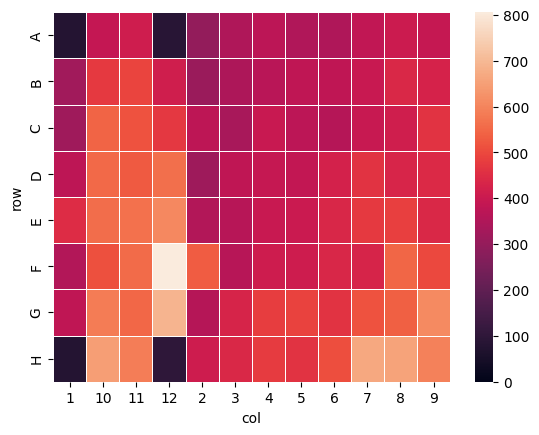

In [75]:
sample_plate = data_plate[(data_plate['RZ_incubation'] == '4H')].copy()

heatmap_df = sample_plate.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

print(sample_plate)

float64


C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: xlabel='col', ylabel='row'>

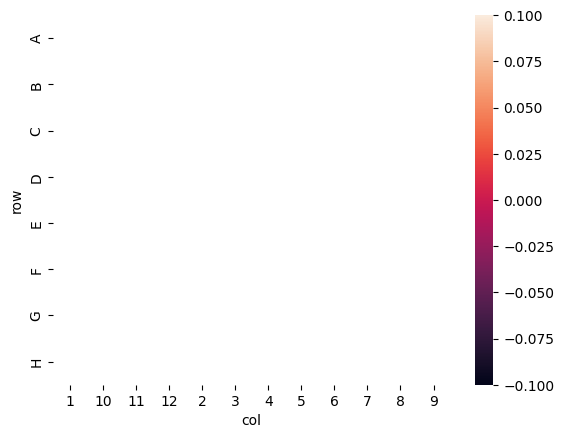

In [76]:
sample_plate['Mean_dif'] = reference_plate['Mean_dif']

sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen'].div(sample_plate['Mean_dif'])

print(sample_plate['Intensity_MeanIntensity_OrigGreen'].dtype)

heatmap_df = sample_plate.pivot(index="row", columns="col", values="Mean_corr")

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)


Blank and control calculation for each plate

In [ ]:
blank_control_array = []

for p in plate:
    blank_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    control_p = data_plate[(data_plate['control'] == 'Yes') & (data_plate['blank'] == 'No') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    blank_std_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].std()
    control_std_p = data_plate[(data_plate['control'] == 'Yes') & (data_plate['blank'] == 'No') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].std()

    bc_array_i = [blank_p,control_p,blank_std_p, control_std_p,p]

    blank_control_array.append(bc_array_i)


blank_control_df = pd.DataFrame(blank_control_array, columns = ['blank_mean', 'control_mean', 'blank_std','control_std','FileName_RGB']) 

print(blank_control_df)




Blank exclusion and relative values calculating

In [ ]:
data_plate_wo_blank_wells = data_plate[data_plate.blank == 'No'].copy() #dataframe without blank

data_plate_with_mean_blank_control = pd.merge(data_plate_wo_blank_wells, blank_control_df, on=['FileName_RGB'])

data_plate_with_mean_blank_control['Green_blanked'] = data_plate_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen'] - data_plate_with_mean_blank_control['blank_mean']
data_plate_with_mean_blank_control['Green_relative'] = data_plate_with_mean_blank_control['Green_blanked']/data_plate_with_mean_blank_control['control_mean']*100

Data selection

In [ ]:
# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['cells'] == 'Vero') & 
#                                                    (data_plate_with_mean_blank_control['sample'] == 'CK')]

# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['substance'] == 'ISK-1')]
# data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['cells'] == 'hTERT')]
data_selected = data_plate_with_mean_blank_control[(data_plate_with_mean_blank_control['substance'] == 'Test 3')]

# print(data_selected['Intensity_IntegratedIntensity_OrigRed'][(data_selected['control'] == 'Yes')])

Plotting


In [ ]:
ax = sns.relplot(data=data_selected, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", kind="line", hue = 'substance')


# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,100))

plt.show()



In [ ]:
ax = sns.stripplot(data=data_plate_with_mean_blank_control, x="row", y="Intensity_MeanIntensity_OrigRed", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()


In [ ]:
ax = sns.relplot(data=data_plate_with_mean_blank_control, x="conc_uM", y="Green_relative", kind="line", 
                 hue = 'substance', col='cells', ci=None)

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,100))

plt.show()

In [ ]:
# ax = sns.heatmap(data=data_selected)
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

# ax.set(ylim = (0,None))

data_selected = data_plate[(data_plate['substance'] == 'Test 3')].copy()

heatmap_df = data_selected.pivot(index="row", columns="col", values="Intensity_IntegratedIntensity_OrigGreen")

# print(heatmap_df)

sns.heatmap(heatmap_df, linewidth=.5, vmin=0, vmax=None)

plt.show()

In [ ]:
row_drop_list = ['A','H']

data_plate_edges_drop = data_plate[~data_plate['row'].isin(row_drop_list)]



In [ ]:
blank_control_array_ED = []

for p in plate:
    mean = data_plate_edges_drop[(data_plate_edges_drop['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

    bc_array_i = [mean,p]

    blank_control_array_ED.append(bc_array_i)


blank_control_df_ED = pd.DataFrame(blank_control_array_ED, columns = ['mean','FileName_RGB']) 

print(blank_control_df_ED)

In [ ]:
DPE_with_mean_blank_control = pd.merge(data_plate_edges_drop, blank_control_df_ED, on=['FileName_RGB'])

DPE_with_mean_blank_control['Mean_dif'] = DPE_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['mean']

DPE_with_mean_blank_control['Mean_corr'] = DPE_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['Mean_dif'] 

print(DPE_with_mean_blank_control['Mean_corr'])

In [ ]:
ax = sns.stripplot(data=DPE_with_mean_blank_control, x="col", y="Mean_corr", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()


In [ ]:
path_to_folder_2 = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-24 Vero Rd hTERT CK-99c ISK-1 + CK-122 Slovesnova"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path_2 = os.path.join(path_to_folder_2, "ExpImage.csv")
data_path_2  = os.path.join(path_to_folder_2, "ExpWells_plate.csv")

data_raw_df_2 = pd.read_csv(data_path_2) 
image_list_df_2 = pd.read_csv(image_list_path_2) 

print(image_list_df_2)


In [ ]:
wellmap_path_list_2 = []

for file in os.listdir(path_to_folder_2):
    if file.endswith(".toml"):
        wellmap_path_list_2.append(os.path.join(path_to_folder_2, file))
        # wellmap_path_list.append(file)

# print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list_2:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df_2 = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

In [ ]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df_2['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df_2 = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df_2)

In [ ]:
data_full_df_2 =  pd.merge(data_raw_df_2, image_list_df_2, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed_2 = pd.concat([row_column_df_2, data_full_df_2], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed_2['col']=data_indexed_2['col'].astype(str) #Otherwise everything will break

data_plate_2 = pd.merge(data_indexed_2, wellmaps_df_2, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate_2[["conc_uM"]] = data_plate_2[["conc_uM"]].apply(pd.to_numeric)

print(data_plate_2.columns)

In [ ]:
data_extracted = data_plate_2[(data_plate_2['FileName_RGB'] == '2024-07-19 Vero CK-122 5H (Multichannel).tif')]

data_extracted['Mean_corr'] = data_extracted['Intensity_MeanIntensity_OrigGreen']/DPE_with_mean_blank_control['Mean_dif']

print(DPE_with_mean_blank_control['Mean_dif'])


#Надо попробовать сделать опорным 0_H планшет

In [ ]:
ax = sns.stripplot(data=data_extracted, x="row", y="Intensity_MeanIntensity_OrigGreen", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()



In [ ]:
ax = sns.stripplot(data=data_extracted, x="row", y="Mean_corr", hue = 'substance')
# ax.set(xscale="symlog")
# ax.set(xlim=(-1, 110))

ax.set(ylim = (0,None))
plt.show()
